# KVASIR Dataset (Simple Neural Network)

Based on [Keras Tutorial: How to get started with Keras, Deep Learning, and Python](https://www.pyimagesearch.com/2018/09/10/keras-tutorial-how-to-get-started-with-keras-deep-learning-and-python/)

Dataset Link: [KVASIR Dataset](https://datasets.simula.no/kvasir/data/kvasir-dataset-v2.zip)

In [1]:
import os
import random

import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers.core import Dense

Using TensorFlow backend.


In [2]:
DATASET_DIRECTORY = "../images"
OUTPUT_DIR = "simple-nn"
CACHE_FILE_NAME = "./cache/cache_32x32_flat.cache"
IMAGE_EXTENSIONS = {"jpg"}

FLATTEN = True
WIDTH = HEIGHT = 32

TEST_PERCENTAGE = 0.2
LEARNING_RATE = 0.01
BATCH_SIZE = 32
N_EPOCHS = 50

## Loading dataset from disk

Gets all paths of images in the `DATASET_DIRECTORY`. Here only `jpg` images are loaded. Then image paths are shuffled to randomize input.

**IPYNB cache files are ignored since they can be included because of ipython notebook cache files.**

In [3]:
def get_image_paths():
    image_paths = []
    for (dir_path, _, file_names) in os.walk(DATASET_DIRECTORY):
        for file_name in file_names:
            if os.extsep not in file_name:
                print("Files without extension found: {}".format(file_name))
                continue
            extension = file_name.split(os.extsep)[-1]
            if extension not in IMAGE_EXTENSIONS:
                print("Non-image files found: {}".format(file_name))
                continue
            if '.ipynb' in dir_path:
                print("IPyNb caches found: {}".format(file_name))
                continue
            image_paths.append(os.path.join(dir_path, file_name))

    random.shuffle(image_paths)

    print(f"Found {len(image_paths)} images")
    return image_paths

In [4]:
image_paths = get_image_paths()

IPyNb caches found: 0053d7cd-549c-48cd-b370-b4ad64a8098a-checkpoint.jpg
IPyNb caches found: 009171b0-52ed-4410-a1e3-410c6e746402-checkpoint.jpg
IPyNb caches found: 0062bbf3-58d7-435d-b0ca-381703c39911-checkpoint.jpg
IPyNb caches found: 00e301cd-5438-4ed7-846b-7d8eaa7cf4b8-checkpoint.jpg
IPyNb caches found: 0046dd24-a4c0-4923-a07a-15be898182e2-checkpoint.jpg
Found 8000 images


Open and process image given by `image_path` and bring the pixel values to 0-1.

In [5]:
def process_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (WIDTH, HEIGHT))
    image = np.array(image, dtype='float') / 255
    if FLATTEN:
        image = image.flatten()
    return image

View one random image of each class after processing.

In [6]:
def get_unique_files_of_labels(base_path, image_extensions={'jpg'}):
    if FLATTEN:
        print("[Cannot view flattened images]")
        return
    
    counter = 0
    nrows = 2
    ncols = 4
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
    
    for (dir_path, _, file_names) in os.walk(base_path):
        u_image_files = []
        for file_name in file_names:
            if os.extsep not in file_name:
                continue
            extension = file_name.split(os.extsep)[-1]
            if extension not in image_extensions:
                continue
            if '.ipynb' in dir_path:
                continue
            u_image_files.append(os.path.join(dir_path, file_name))
        
        if len(u_image_files) == 0:
            continue
        u_image_file = random.choice(u_image_files)

        col, row = counter%ncols, counter//ncols
        counter += 1
        
        ax[row, col].imshow(process_image(u_image_file))
        ax[row, col].axis('off')
    print("Random processed images of each class")
    plt.show()
    
get_unique_files_of_labels(DATASET_DIRECTORY)

[Cannot view flattened images]


Load dataset from `DATASET_DIRECTORY` into memory and return a tuple of (images, labels) where `image[i]` is the i'th preprocessed image normalized into 0-1 range and `labels[i]` is the label of i'th image.

`DATASET_DIRECTORY` must have directories representing labels and images inside each directory.

In [7]:
def load():
    images = []
    labels = []
    
    print("Searching for cache file: " + CACHE_FILE_NAME)

    if os.path.exists(CACHE_FILE_NAME):
        print("Cache file found. Loading from cache.")
        with open(CACHE_FILE_NAME, 'rb') as fr:
            images, labels = pickle.load(fr)
    else:
        print("Cache file not found")
        print("Started loading dataset")

        for ind, image_path in enumerate(image_paths):
            image = process_image(image_path)
            label = image_path.split(os.path.sep)[-2]

            images.append(image)
            labels.append(label)

            print(f"Loaded {ind}/{len(image_paths)} images.", end="\r")

        print()

        images = np.array(images, dtype='float')
        labels = np.array(labels)

        with open(CACHE_FILE_NAME, 'wb') as fw:
            pickle.dump((images, labels), fw)

    print("Dataset loaded into memory")
    return images, labels 

In [8]:
images, labels = load()

Searching for cache file: ./cache/cache_32x32_flat.cache
Cache file found. Loading from cache.
Dataset loaded into memory


In [9]:
if not FLATTEN:
    plt.title(labels[0])
    plt.imshow(images[0])
    plt.show()

## Split into training and testing sets

Keras will assume that,
* Labels are encoded as integers
* Labels are on-hot encoded

So labels have to be encoded as such. For this scikit learn label binarizer is used. However if this is 2-class only, use Keras' `to_categorical` function.

In [10]:
label_binarizer = LabelBinarizer()
encoded_labels = label_binarizer.fit_transform(labels)
class_names = label_binarizer.classes_

Split into test and train datasets.

In [11]:
train_x, test_x, train_y, test_y = train_test_split(images, encoded_labels,
                                                    test_size=TEST_PERCENTAGE,
                                                    stratify=encoded_labels)

In [12]:
if not FLATTEN:
    plt.title(str(train_y[0]))
    plt.imshow(train_x[0])
    plt.show()

In [13]:
if not FLATTEN:
    plt.title(str(test_y[0]))
    plt.imshow(test_x[0])
    plt.show()

## Defining and Compiling Keras Model Architecture

![Architecture](https://www.pyimagesearch.com/wp-content/uploads/2018/09/keras_tutorial_simplenn_arch.png)

Compile a simple feed forward neural network.

`(Dense => Sigmoid) => (Dense => Sigmoid) => (Dense => Sigmoid) => (Dense => Sigmoid)`

In [14]:
input_shape = (WIDTH*HEIGHT*3, )
output_nodes = len(class_names)

model = Sequential()
model.add(Dense(1024, input_shape=input_shape, activation='sigmoid'))
model.add(Dense(512, activation='sigmoid'))
model.add(Dense(output_nodes, activation='sigmoid'))

optimizer = SGD(lr=LEARNING_RATE)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

W0827 16:38:18.782067 139855890442048 deprecation_wrapper.py:119] From /home/kdsuneraavinash/Programs/miniconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0827 16:38:19.012741 139855890442048 deprecation_wrapper.py:119] From /home/kdsuneraavinash/Programs/miniconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0827 16:38:19.121871 139855890442048 deprecation_wrapper.py:119] From /home/kdsuneraavinash/Programs/miniconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0827 16:38:19.359314 139855890442048 deprecation_wrapper.py:119] From /home/kdsuneraavinash/Programs/miniconda3/envs/tf/lib/python3.7/site-packages/keras/optimizers.p

## Training the Model

In [15]:
history = model.fit(x=train_x,
                    y=train_y,
                    batch_size=BATCH_SIZE,
                    epochs=N_EPOCHS,
                    validation_data=(test_x, test_y))

W0827 16:38:19.950329 139855890442048 deprecation.py:323] From /home/kdsuneraavinash/Programs/miniconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0827 16:38:19.991503 139855890442048 deprecation_wrapper.py:119] From /home/kdsuneraavinash/Programs/miniconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 6400 samples, validate on 1600 samples
Epoch 1/50
6400/6400 [==============================] - 8s 1ms/step - loss: 2.0730 - acc: 0.1531 - val_loss: 2.0518 - val_acc: 0.1263
Epoch 2/50
6400/6400 [==============================] - 5s 808us/step - loss: 2.0277 - acc: 0.2175 - val_loss: 1.9907 - val_acc: 0.3337
Epoch 3/50
6400/6400 [==============================] - 6s 864us/step - loss: 1.9371 - acc: 0.3311 - val_loss: 1.8679 - val_acc: 0.3563
Epoch 4/50
6400/6400 [==============================] - 6s 873us/step - loss: 1.7946 - acc: 0.3758 - val_loss: 1.7112 - val_acc: 0.4250
Epoch 5/50
6400/6400 [==============================] - 6s 862us/step - loss: 1.6341 - acc: 0.4344 - val_loss: 1.5604 - val_acc: 0.4256
Epoch 6/50
6400/6400 [==============================] - 7s 1ms/step - loss: 1.4885 - acc: 0.4755 - val_loss: 1.4330 - val_acc: 0.4294
Epoch 7/50
6400/6400 [==============================] - 7s 1ms/step - loss: 1.3736 - acc: 0.5044 - val_loss: 1.3271 - val_acc: 0.5238
Epoch 

## Evaluating the model

Generate report on test data

In [16]:
def evaluation_report():
    predictions = model.predict(test_x, batch_size=BATCH_SIZE)

    y_true = test_y.argmax(axis=1)
    y_pred = predictions.argmax(axis=1)

    report = classification_report(y_true, y_pred, target_names=class_names)

    report_output_path = os.path.join(OUTPUT_DIR, 'evaluation.txt')

    with open(report_output_path, 'w') as fw:
        fw.write(str(report))

    print(report)

Generate, show and save a plot on accurcy and loss by epoch number

In [17]:
def chart():
    x_axis_values = np.arange(0, N_EPOCHS)
    plt.style.use('seaborn-white')
    plt.figure()

    plt.plot(x_axis_values, history.history['loss'], label='Loss(Train)')
    plt.plot(x_axis_values,
             history.history['val_loss'], label='Loss(Test)')
    plt.plot(x_axis_values,
             history.history['acc'], label='Accuracy(Train)')
    plt.plot(x_axis_values,
             history.history['val_acc'], label='Accuracy(Test)')

    plt.title("Training Loss and Accuracy (Simple Neural Network)")
    plt.xlabel("Epoch Number")
    plt.ylabel("Loss/Accuracy")
    plt.legend()

    chart_output_path = os.path.join(OUTPUT_DIR, 'chart')
    plt.savefig(chart_output_path)
    plt.show()

In [18]:
evaluation_report()

                        precision    recall  f1-score   support

    dyed-lifted-polyps       0.57      0.43      0.49       200
dyed-resection-margins       0.60      0.75      0.67       200
           esophagitis       0.86      0.60      0.71       200
          normal-cecum       0.69      0.93      0.79       200
        normal-pylorus       0.89      0.89      0.89       200
         normal-z-line       0.63      0.85      0.72       200
                polyps       0.66      0.47      0.55       200
    ulcerative-colitis       0.76      0.69      0.72       200

              accuracy                           0.70      1600
             macro avg       0.71      0.70      0.69      1600
          weighted avg       0.71      0.70      0.69      1600



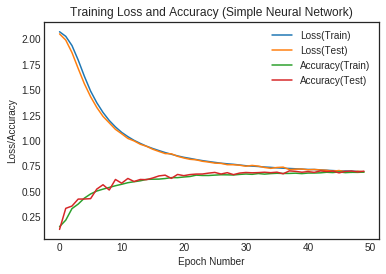

In [19]:
chart()

Saving model and classes

In [20]:
classes_output_path = os.path.join(OUTPUT_DIR, 'classes.txt')
model_output_path = os.path.join(OUTPUT_DIR, 'model.hdf5')

model.save(model_output_path)
with open(classes_output_path, 'w') as fw:
    fw.write('\n'.join(class_names))

## Predicting for new data

In [21]:
from keras.models import load_model

In [22]:
WIDTH = HEIGHT = 32
OUTPUT_DIR = "simple-nn"

IMAGE_LOAD_PATH = "../images/dyed-resection-margins/016cc0c1-2a9e-464c-884f-0997561f7dde.jpg"

In [23]:
image = process_image(IMAGE_LOAD_PATH)
image = image.reshape(1, image.shape[0])

model_output_path = os.path.join(OUTPUT_DIR, 'model.hdf5')
classes_output_path = os.path.join(OUTPUT_DIR, 'classes.txt')

model = load_model(model_output_path)

class_names = []
with open(classes_output_path, 'r') as f:
    for line in f.readlines():
        class_names.append(line.strip())

prediction = model.predict(image)

pred_i = prediction.argmax(axis=1)[0]
predicted_label = class_names[pred_i]

Draw output prediction on the image.

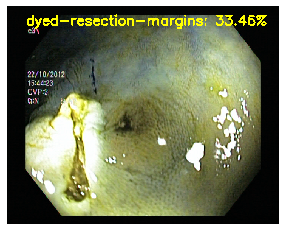

In [24]:
output = cv2.imread(IMAGE_LOAD_PATH)

text = "{}: {:.2f}%".format(predicted_label, prediction[0][pred_i] * 100)

cv2.putText(output, text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.2,
	(255, 255, 0), 3)

plt.axis('off')
plt.imshow(output)
plt.show()